# Оцінювання кінетичних параметрів за допомогою Differential Evolution

**"Диференціальна еволюція для параметричної оптимізації"**

Мета:

1. Задати нелінійну регресійну (кінетичну) модель з **8 невідомими параметрами**.
2. Згенерувати «експериментальні» дані (synthetic data) на основі відомих істинних параметрів і доданого шуму.
3. Сформувати функцію помилки (середньоквадратичне відхилення між модельними та експериментальними значеннями).
4. Оцінити параметри за допомогою алгоритму **Differential Evolution (DE)** та порівняти три стратегії мутації:
   - `DE/rand/1/bin` (випадкова базова мутація),
   - `DE/best/1/bin` (мутація від найкращого індивіда),
   - `DE/current-to-best/1/bin` (напрямлена мутація).
5. Виконати **50 незалежних запусків** для кожної стратегії, оцінити:
   - швидкість збіжності;
   - надійність досягнення глобального оптимуму;
   - точність відновлення істинних параметрів моделі.

Умови, що відповідають постановці задачі:

- Розмір популяції — близько \(NP = 50\) (у SciPy \(NP = popsize * D\), тому беремо `popsize = 6`, що дає \(NP = 48\)).
- Коефіцієнт масштабування \(F = 0,8\).
- Ймовірність схрещування \(CR = 0,9\).


In [33]:
# !pip install pymoo

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution as scipy_de

from pymoode.algorithms import DE
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.core.callback import Callback


## 1. Кінетична модель з 8 параметрами

Розглянемо реакційну швидкість як функцію температури (T) та концентрацій двох реагентів (C_A) і (C_B):

$$
r(T, C_A, C_B; \boldsymbol{\theta}) =
\theta_1, T^{\theta_2},
\exp!\left( -\frac{\theta_3}{RT} \right)
C_A^{\theta_4} C_B^{\theta_5}
\left(1 + \theta_6 C_A + \theta_7 C_B \right)^{\theta_8}.
$$

де:

* (T) — температура (K),
* (C_A, C_B) — концентрації реагентів,
* (R) — газова стала,
* (\boldsymbol{\theta} = (\theta_1, \dots, \theta_8)) — вектор невідомих параметрів.

Фізичний зміст параметрів:

* (\theta_1) — масштабний (преекспоненційний) коефіцієнт;
* (\theta_2) — степенева залежність по температурі;
* (\theta_3) — ефективна енергія активації (в тих же одиницях, що й (RT));
* (\theta_4, \theta_5) — порядки реакції за концентраціями (C_A) та (C_B);
* (\theta_6, \theta_7) — коефіцієнти корекційних членів по концентраціях;
* (\theta_8) — показник степеня корекційного множника.

Саме (\boldsymbol{\theta}) ми будемо ідентифікувати методом DE.


In [34]:
R = 8.314  # газова стала, Дж/(моль*K)

def rate_model(theta, T, C_A, C_B):
    """
    Кінетична модель:
    r = θ1 * T^θ2 * exp(-θ3/(R*T)) * C_A^θ4 * C_B^θ5 * (1 + θ6*C_A + θ7*C_B)^θ8
    """
    θ1, θ2, θ3, θ4, θ5, θ6, θ7, θ8 = theta

    base = 1 + θ6*C_A + θ7*C_B
    base = np.maximum(base, 1e-8)

    return (θ1 * T**θ2 * np.exp(-θ3/(R*T)) *
            C_A**θ4 * C_B**θ5 *
            base**θ8)

## 2. Генерація синтетичних експериментальних даних

У завданні потрібно калібрувати модель за експериментальними даними.
Оскільки реальні дані відсутні, будемо використовувати **synthetic data**:

1. Задаємо «істинні» параметри \(\boldsymbol{\theta}^{\text{true}}\).
2. Генеруємо сітку значень \(T, C_A, C_B\).
3. Обчислюємо істинні швидкості:
   \[
   r_k^{\text{true}} = r(T_k, C_{A,k}, C_{B,k}; \boldsymbol{\theta}^{\text{true}}).
   \]
4. Додаємо гаусівський шум:
   \[
   r_k^{\text{exp}} = r_k^{\text{true}} (1 + \varepsilon_k),
   \quad
   \varepsilon_k \sim \mathcal{N}(0, \sigma^2).
   \]

Так отримуємо "експериментальні" дані, на яких будемо відновлювати параметри.

In [35]:
# істинні параметри (приховані від "алгоритму")
theta_true = np.array([
    5.0,      # θ1
    0.5,      # θ2
    80000.0,  # θ3
    1.0,      # θ4
    1.2,      # θ5
    0.1,      # θ6
    -0.05,    # θ7
    2.0       # θ8
])

# сітка значень T, C_A, C_B
T_vals   = np.linspace(300, 500, 10)
C_A_vals = np.linspace(0.5, 1.5, 10)
C_B_vals = np.linspace(0.4, 1.2, 10)

TT, CA, CB = np.meshgrid(T_vals, C_A_vals, C_B_vals, indexing="ij")

T_data   = TT.flatten()
C_A_data = CA.flatten()
C_B_data = CB.flatten()

# істинні значення швидкості
y_true = rate_model(theta_true, T_data, C_A_data, C_B_data)

# додаємо ~5% шуму
np.random.seed(0)
noise = 0.05 * np.random.randn(y_true.size)
y_exp = y_true * (1.0 + noise)

N = y_exp.size
print("Кількість експериментальних точок:", N)


Кількість експериментальних точок: 1000


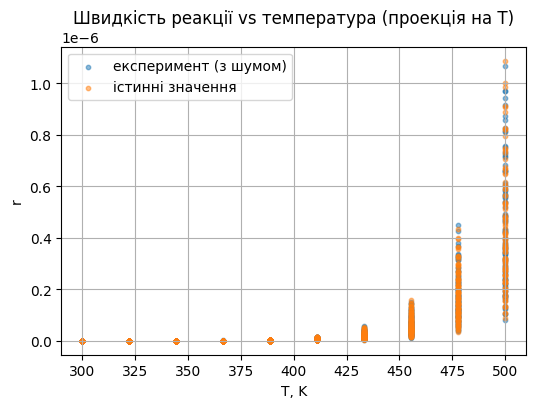

In [36]:
plt.figure(figsize=(6,4))
plt.scatter(T_data, y_exp, s=10, alpha=0.5, label="експеримент (з шумом)")
plt.scatter(T_data, y_true, s=10, alpha=0.5, label="істинні значення")
plt.xlabel("T, K")
plt.ylabel("r")
plt.legend()
plt.title("Швидкість реакції vs температура (проекція на T)")
plt.grid(True)
plt.savefig('data_plot.png')
plt.show()

## 3. Функція цілі (середньоквадратична помилка)

Для заданого набору параметрів \(\boldsymbol{\theta}\) модель дає прогноз:

\[
\hat{r}_k(\boldsymbol{\theta}) = r(T_k, C_{A,k}, C_{B,k}; \boldsymbol{\theta}).
\]

Функцію помилки визначимо як середньоквадратичне відхилення:

\[
J(\boldsymbol{\theta}) =
\frac{1}{N} \sum_{k=1}^{N}
\left[ \hat{r}_k(\boldsymbol{\theta}) - r^{\text{exp}}_k \right]^2.
\]

Саме \(J(\boldsymbol{\theta})\) мінімізуємо методом DE.

In [37]:
def objective(theta):
    y_pred = rate_model(theta, T_data, C_A_data, C_B_data)
    return np.mean((y_pred - y_exp)**2)

print("J(theta_true) =", objective(theta_true))

J(theta_true) = 5.605226083618989e-17


## 4. Межі параметрів

Виберемо такі діапазони для параметрів (їх можна адаптувати):

- \(\theta_1 \in [0.01, 1000]\)
- \(\theta_2 \in [-2, 2]\)
- \(\theta_3 \in [5000, 200000]\)
- \(\theta_4, \theta_5 \in [0, 3]\)
- \(\theta_6, \theta_7 \in [-2, 2]\)
- \(\theta_8 \in [0, 5]\)

Ці межі будуть використані DE для генерації початкової популяції
та відсікання некоректних рішень.

In [38]:
bounds = [
    (0.01, 1000),   # θ1
    (-2,  2),       # θ2
    (5000, 200000), # θ3
    (0, 3),         # θ4
    (0, 3),         # θ5
    (-2, 2),        # θ6
    (-2, 2),        # θ7
    (0, 5)          # θ8
]

dim = len(bounds)
print("Розмірність задачі D =", dim)

Розмірність задачі D = 8


## 5. Алгоритм Differential Evolution (DE)

DE - це популяційний еволюційний алгоритм глобальної оптимізації для неперервних задач.

Нехай на поколінні \(g\) маємо популяцію з \(NP\) векторів:

\[
\mathbf{x}_i^{(g)} = (x_{i,1}^{(g)}, \dots, x_{i,D}^{(g)}), \quad i = 1,\dots,NP.
\]

### 5.1. Мутація

Для кожного індивіда (цільового вектора) \(\mathbf{x}_i^{(g)}\) створюється донорний вектор \(\mathbf{v}_i^{(g)}\).

**Стратегія DE/rand/1:**

\[
\mathbf{v}_i = \mathbf{x}_{r1} + F(\mathbf{x}_{r2} - \mathbf{x}_{r3}),
\]

де \(r1, r2, r3\) — різні індекси, випадково обрані з \(\{1,\dots,NP\}\),
а \(F \in (0,2)\) — коефіцієнт масштабування (у нас \(F=0.8\)).

**Стратегія DE/best/1:**

\[
\mathbf{v}_i = \mathbf{x}_{\text{best}} + F(\mathbf{x}_{r1} - \mathbf{x}_{r2}),
\]

де \(\mathbf{x}_{\text{best}}\) — найкращий вектор у поточній популяції.

**Стратегія DE/current-to-best/1:**

\[
\mathbf{v}_i = \mathbf{x}_i +
F(\mathbf{x}_{\text{best}} - \mathbf{x}_i) +
F(\mathbf{x}_{r1} - \mathbf{x}_{r2}).
\]

### 5.2. Кросовер (binomial)

Формується випробувальний вектор \(\mathbf{u}_i\):

\[
u_{i,j} =
\begin{cases}
v_{i,j}, & \text{якщо } \mathrm{rand}_j \leq CR \text{ або } j=j_{\text{rand}}, \\
x_{i,j}, & \text{інакше},
\end{cases}
\]

де \(CR \in [0,1]\) — ймовірність схрещування (у нас \(CR=0.9\)),
а \(j_{\text{rand}}\) гарантує, що хоча б одна координата взята з \(\mathbf{v}_i\).

### 5.3. Селекція

Порівнюємо значення цільової функції:

\[
J(\mathbf{x}_i), \quad J(\mathbf{u}_i).
\]

Якщо \(J(\mathbf{u}_i) \le J(\mathbf{x}_i)\), то в наступне покоління переходить \(\mathbf{u}_i\),
інакше — \(\mathbf{x}_i\). Це називається **жадібна селекція** (greedy).

Цикл "мутація -> кросовер -> селекція" повторюється до досягнення критерію зупинки.

## 6. Реалізація DE/rand/1/bin та DE/best/1/bin у SciPy

Функція `scipy.optimize.differential_evolution` підтримує кілька стратегій,
зокрема:

- `"rand1bin"`  → `DE/rand/1/bin`;
- `"best1bin"`  → `DE/best/1/bin`.

Популяція задається як:

\[
NP = \text{popsize} \cdot D.
\]

Нам потрібно \(NP \approx 50\), а \(D = 8\), тому беремо `popsize = 6`
(одержуємо \(NP = 48\), що близько до вимоги).

In [39]:
def run_scipy_de(strategy, seed, maxiter=200):
    """
    Запуск SciPy Differential Evolution:
    strategy: "rand1bin" або "best1bin".
    """
    result = scipy_de(
        objective,
        bounds,
        strategy=strategy,
        maxiter=maxiter,
        popsize=6,        # NP = 6 * 8 = 48 
        mutation=0.8,
        recombination=0.9,
        seed=seed,
        polish=False
    )
    return result.fun, result.x


def run_scipy_de_with_history(strategy, seed, maxiter=200):
    """
    Те ж саме, але з історією найкращого значення J для побудови графіків збіжності.
    """
    history = []

    def callback(xk, convergence):
        history.append(objective(xk))

    result = scipy_de(
        objective,
        bounds,
        strategy=strategy,
        maxiter=maxiter,
        popsize=6,
        mutation=0.8,
        recombination=0.9,
        seed=seed,
        polish=False,
        callback=callback
    )
    return result.fun, result.x, history


## 7. Реалізація DE/current-to-best/1/bin у pymoo

У бібліотеці **pymoo** ми описуємо задачу через клас `ElementwiseProblem`,
а алгоритм DE задаємо як:

- `variant="DE/current-to-best/1/bin"`.

Це відповідає мутації:

\[
\mathbf{v}_i = \mathbf{x}_i +
F(\mathbf{x}_{\text{best}} - \mathbf{x}_i) +
F(\mathbf{x}_{r1} - \mathbf{x}_{r2}),
\]

з біноміальним кросовером (bin).

In [40]:
class KineticProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=dim,
            n_obj=1,
            n_constr=0,
            xl=np.array([b[0] for b in bounds]),
            xu=np.array([b[1] for b in bounds])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = objective(x)


class ConvergenceTracker(Callback):
    def __init__(self):
        super().__init__()
        self.history = []

    def notify(self, algorithm):
        best = algorithm.pop.get("F").min()
        self.history.append(best)


def run_pymoo_current_to_best(seed, n_gen=200):
    problem = KineticProblem()

    algorithm = DE(
        pop_size=48,  
        variant="DE/current-to-best/1/bin",
        F=0.8,
        CR=0.9
    )

    termination = get_termination("n_gen", n_gen)
    tracker = ConvergenceTracker()

    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=seed,
                   callback=tracker,
                   verbose=False)

    return res.F[0], res.X, tracker.history


## 8. Експерименти: 50 незалежних запусків для кожної стратегії

Для кожної стратегії:

- `DE/rand/1/bin` (SciPy),
- `DE/best/1/bin` (SciPy),
- `DE/current-to-best/1/bin` (pymoo),

виконуємо **50 незалежних запусків** з різними seed. Для кожного запуску
зберігаємо:

- найкраще знайдене значення MSE,
- (для першого запуску) історію збіжності для графіків,
- найкращий вектор параметрів.

Також будемо відстежувати **найкращий серед усіх запусків** вектор параметрів,
щоб порівняти його з істинними \(\boldsymbol{\theta}^{\text{true}}\).

In [41]:
n_runs = 50
maxiter_scipy = 200
n_gen_pymoo = 200

results_rand = []
results_best = []
results_current = []

# історії для одного запуску кожної стратегії
conv_rand_example = None
conv_best_example = None
conv_current_example = None

# найкращі параметри по всіх запусках
best_mse_rand = np.inf
best_theta_rand = None

best_mse_best = np.inf
best_theta_best = None

best_mse_current = np.inf
best_theta_current = None

for i in range(n_runs):
    print(f"Run {i+1:02d}/{n_runs}", end="\r")

    # --- DE/rand/1/bin ---
    if i == 0:
        f_rand, x_rand, hist_rand = run_scipy_de_with_history("rand1bin", seed=i, maxiter=maxiter_scipy)
        conv_rand_example = hist_rand
    else:
        f_rand, x_rand = run_scipy_de("rand1bin", seed=i, maxiter=maxiter_scipy)
    results_rand.append(f_rand)
    if f_rand < best_mse_rand:
        best_mse_rand = f_rand
        best_theta_rand = x_rand

    # --- DE/best/1/bin ---
    if i == 0:
        f_best, x_best, hist_best = run_scipy_de_with_history("best1bin", seed=1000+i, maxiter=maxiter_scipy)
        conv_best_example = hist_best
    else:
        f_best, x_best = run_scipy_de("best1bin", seed=1000+i, maxiter=maxiter_scipy)
    results_best.append(f_best)
    if f_best < best_mse_best:
        best_mse_best = f_best
        best_theta_best = x_best

    # --- DE/current-to-best/1/bin (pymoo) ---
    if i == 0:
        f_curr, x_curr, hist_curr = run_pymoo_current_to_best(seed=2000+i, n_gen=n_gen_pymoo)
        conv_current_example = hist_curr
    else:
        f_curr, x_curr, _ = run_pymoo_current_to_best(seed=2000+i, n_gen=n_gen_pymoo)
    results_current.append(f_curr)
    if f_curr < best_mse_current:
        best_mse_current = f_curr
        best_theta_current = x_curr

print("\nГотово.")


Run 50/50
Готово.

Готово.


In [42]:
results_rand = np.array(results_rand)
results_best = np.array(results_best)
results_current = np.array(results_current)

print("===== Підсумкові результати (Mean ± Std) MSE =====")
print(f"DE/rand/1/bin         : {results_rand.mean():.6e} ± {results_rand.std():.6e}")
print(f"DE/best/1/bin         : {results_best.mean():.6e} ± {results_best.std():.6e}")
print(f"DE/current-to-best/1  : {results_current.mean():.6e} ± {results_current.std():.6e}")


===== Підсумкові результати (Mean ± Std) MSE =====
DE/rand/1/bin         : 9.145788e-17 ± 2.780881e-17
DE/best/1/bin         : 5.399642e-17 ± 1.420670e-18
DE/current-to-best/1  : 5.421028e-17 ± 2.214545e-18


/var/folders/tt/_3ywz8k966s1ps_dnfnpgfy40000gn/T/ipykernel_52002/2776682284.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_rand, results_best, results_current],


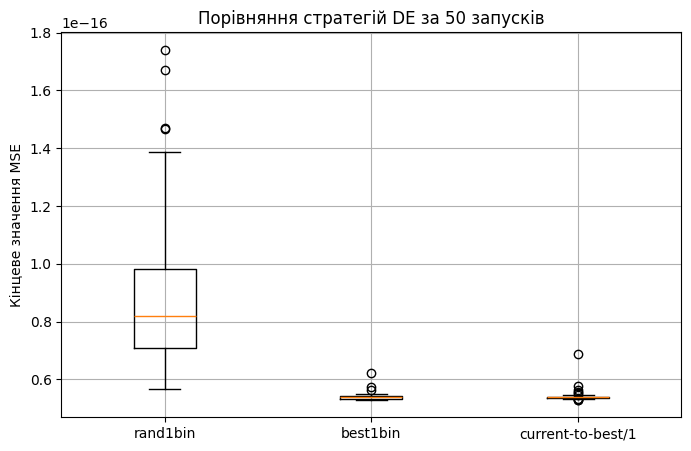

In [43]:
plt.figure(figsize=(8,5))
plt.boxplot([results_rand, results_best, results_current],
            labels=["rand1bin", "best1bin", "current-to-best/1"])
plt.ylabel("Кінцеве значення MSE")
plt.title("Порівняння стратегій DE за 50 запусків")
plt.grid(True)
plt.savefig('boxplot.png')
plt.show()

## 9. Приклади збіжності по поколіннях

На одному запуску для кожної стратегії подивимося,
як зменшується найкраще значення функції \(J(\boldsymbol{\theta})\) по поколіннях.
Це дає уявлення про швидкість збіжності й стабільність алгоритмів.


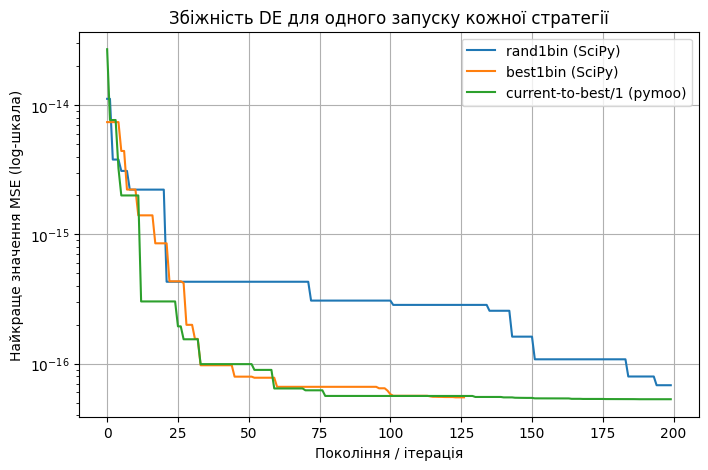

In [44]:
plt.figure(figsize=(8,5))

if conv_rand_example is not None:
    plt.semilogy(conv_rand_example, label="rand1bin (SciPy)")

if conv_best_example is not None:
    plt.semilogy(conv_best_example, label="best1bin (SciPy)")

if conv_current_example is not None:
    plt.semilogy(conv_current_example, label="current-to-best/1 (pymoo)")

plt.xlabel("Покоління / ітерація")
plt.ylabel("Найкраще значення MSE (log-шкала)")
plt.title("Збіжність DE для одного запуску кожної стратегії")
plt.grid(True)
plt.legend()
plt.savefig('convergence.png')
plt.show()

## 10. Порівняння відновлених параметрів з істинними

Тепер порівняємо:

- істинний вектор параметрів \(\boldsymbol{\theta}^{\text{true}}\);
- найкращий (за найменшим MSE) вектор, знайдений кожною стратегією:
  - \(\hat{\boldsymbol{\theta}}_{\text{rand}}\),
  - \(\hat{\boldsymbol{\theta}}_{\text{best}}\),
  - \(\hat{\boldsymbol{\theta}}_{\text{curr-best}}\).

Це покаже точність відновлення параметрів, а не лише помилку на даних.


In [45]:
param_names = [f"θ{i+1}" for i in range(dim)]

print("Найкращий MSE для кожної стратегії:")
print(f"rand1bin        : {best_mse_rand:.6e}")
print(f"best1bin        : {best_mse_best:.6e}")
print(f"current-to-best : {best_mse_current:.6e}")
print()

print("{:>4s}  {:>12s}  {:>12s}  {:>12s}  {:>12s}".format(
    "par", "true", "rand1bin", "best1bin", "curr-best"))
print("-"*60)
for i, name in enumerate(param_names):
    t_true = theta_true[i]
    t_r = best_theta_rand[i]
    t_b = best_theta_best[i]
    t_c = best_theta_current[i]
    print("{:>4s}  {:12.6g}  {:12.6g}  {:12.6g}  {:12.6g}".format(
        name, t_true, t_r, t_b, t_c))

Найкращий MSE для кожної стратегії:
rand1bin        : 5.675406e-17
best1bin        : 5.289841e-17
current-to-best : 5.296139e-17

 par          true      rand1bin      best1bin     curr-best
------------------------------------------------------------
  θ1             5        841.26       687.275       429.063
  θ2           0.5     -0.249582     -0.115106     -0.060283
  θ3         80000       82276.5       83651.4       83214.9
  θ4             1       1.04256       1.12006       1.16072
  θ5           1.2       1.09505       1.24549       1.19178
  θ6           0.1       1.25348     0.0150022     0.0214154
  θ7         -0.05    -0.0473146    -0.0437627     -0.405303
  θ8             2       0.23107       3.72805      0.166437


## 12. Візуалізація кінетичної функції — 3D поверхня

Щоб краще побачити нелінійність моделі, побудуємо поверхню:

\[
r(T, C_A) = r(T, C_A, C_B^{(0)}; \boldsymbol{\theta})
\]

при фіксованому \(C_B^{(0)}\).

На графіку по осях:
- \(x\) — температура \(T\),
- \(y\) — концентрація \(C_A\),
- \(z\) — швидкість \(r\).

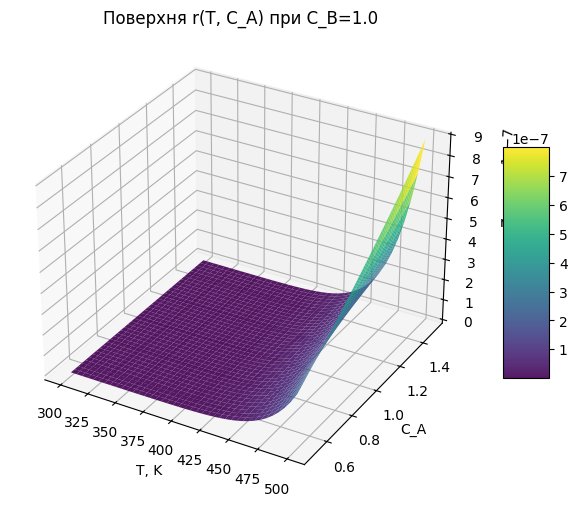

In [46]:
from mpl_toolkits.mplot3d import Axes3D  # потрібно для 3D-проєкції

theta_vis = theta_true          # або одна з оцінених множин параметрів
CB0 = 1.0                       # фіксоване значення C_B

T_grid = np.linspace(300, 500, 40)
CA_grid = np.linspace(0.5, 1.5, 40)
TTg, CAg = np.meshgrid(T_grid, CA_grid, indexing="ij")

T_flat = TTg.flatten()
CA_flat = CAg.flatten()
CB_flat = CB0 * np.ones_like(T_flat)

r_flat = rate_model(theta_vis, T_flat, CA_flat, CB_flat)
R_grid = r_flat.reshape(TTg.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(TTg, CAg, R_grid, cmap='viridis', alpha=0.9)

ax.set_xlabel("T, K")
ax.set_ylabel("C_A")
ax.set_zlabel("r")
ax.set_title(f"Поверхня r(T, C_A) при C_B={CB0}")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('surface_3d.png', dpi=150, bbox_inches='tight')
plt.show()

## Додаткові 3D візуалізації з різними фіксованими параметрами

Створимо серію візуалізацій для різних комбінацій параметрів:

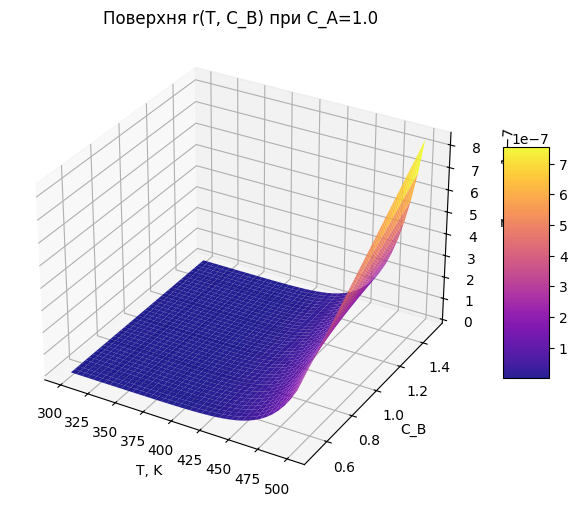

In [47]:
# Візуалізація 1: r(T, C_B) при фіксованому C_A
from mpl_toolkits.mplot3d import Axes3D

theta_vis = theta_true
CA_fixed = 1.0  # фіксоване значення C_A

T_grid = np.linspace(300, 500, 40)
CB_grid = np.linspace(0.5, 1.5, 40)
TT_mesh, CB_mesh = np.meshgrid(T_grid, CB_grid, indexing="ij")

T_flat = TT_mesh.flatten()
CB_flat = CB_mesh.flatten()
CA_flat = CA_fixed * np.ones_like(T_flat)

r_flat = rate_model(theta_vis, T_flat, CA_flat, CB_flat)
R_grid = r_flat.reshape(TT_mesh.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(TT_mesh, CB_mesh, R_grid, cmap='plasma', alpha=0.9)

ax.set_xlabel("T, K")
ax.set_ylabel("C_B")
ax.set_zlabel("r")
ax.set_title(f"Поверхня r(T, C_B) при C_A={CA_fixed}")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('surface_T_CB.png', dpi=150, bbox_inches='tight')
plt.show()

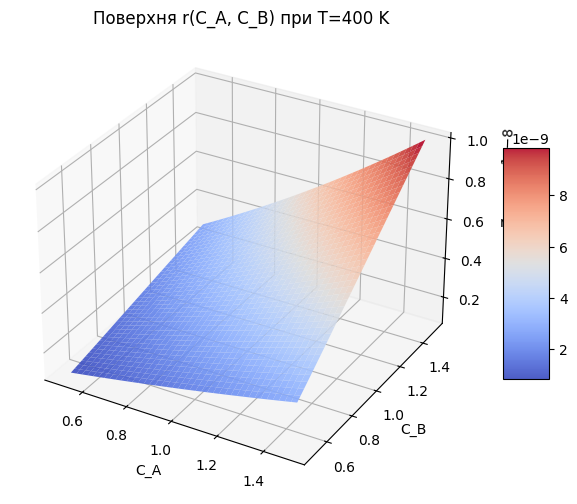

In [48]:
# Візуалізація 2: r(C_A, C_B) при фіксованій температурі
T_fixed = 400  # фіксована температура, K

CA_grid = np.linspace(0.5, 1.5, 40)
CB_grid = np.linspace(0.5, 1.5, 40)
CA_mesh, CB_mesh = np.meshgrid(CA_grid, CB_grid, indexing="ij")

CA_flat = CA_mesh.flatten()
CB_flat = CB_mesh.flatten()
T_flat = T_fixed * np.ones_like(CA_flat)

r_flat = rate_model(theta_vis, T_flat, CA_flat, CB_flat)
R_grid = r_flat.reshape(CA_mesh.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(CA_mesh, CB_mesh, R_grid, cmap='coolwarm', alpha=0.9)

ax.set_xlabel("C_A")
ax.set_ylabel("C_B")
ax.set_zlabel("r")
ax.set_title(f"Поверхня r(C_A, C_B) при T={T_fixed} K")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('surface_CA_CB.png', dpi=150, bbox_inches='tight')
plt.show()

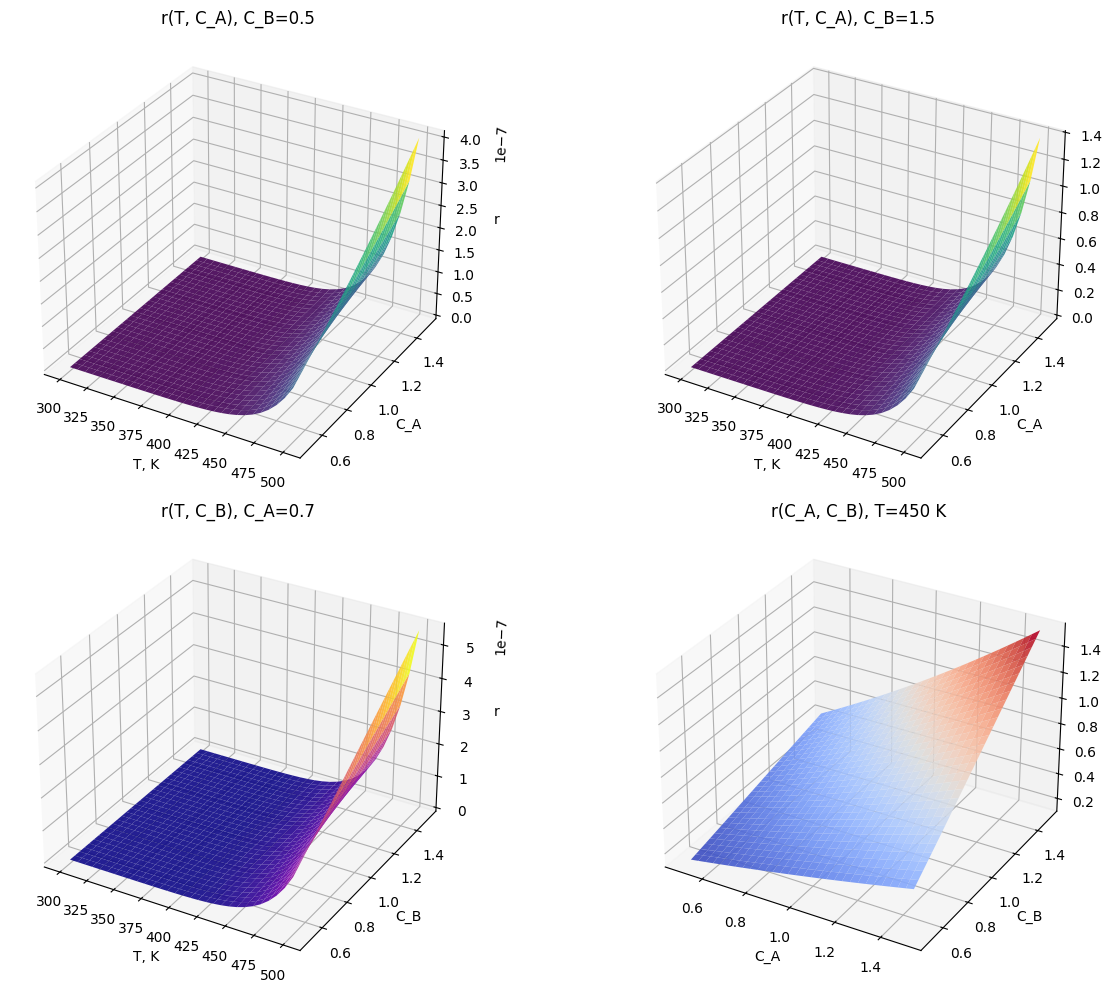

In [49]:
# Візуалізація 3: Комбінований графік - 4 підграфіки з різними фіксованими параметрами
fig = plt.figure(figsize=(14, 10))

# Підграфік 1: r(T, C_A) при C_B = 0.5
ax1 = fig.add_subplot(2, 2, 1, projection="3d")
CB_fix = 0.5
T_grid = np.linspace(300, 500, 30)
CA_grid = np.linspace(0.5, 1.5, 30)
TT, CA = np.meshgrid(T_grid, CA_grid, indexing="ij")
r = rate_model(theta_vis, TT.flatten(), CA.flatten(), CB_fix * np.ones_like(TT.flatten()))
surf1 = ax1.plot_surface(TT, CA, r.reshape(TT.shape), cmap='viridis', alpha=0.9)
ax1.set_xlabel("T, K")
ax1.set_ylabel("C_A")
ax1.set_zlabel("r")
ax1.set_title(f"r(T, C_A), C_B={CB_fix}")

# Підграфік 2: r(T, C_A) при C_B = 1.5
ax2 = fig.add_subplot(2, 2, 2, projection="3d")
CB_fix = 1.5
r = rate_model(theta_vis, TT.flatten(), CA.flatten(), CB_fix * np.ones_like(TT.flatten()))
surf2 = ax2.plot_surface(TT, CA, r.reshape(TT.shape), cmap='viridis', alpha=0.9)
ax2.set_xlabel("T, K")
ax2.set_ylabel("C_A")
ax2.set_zlabel("r")
ax2.set_title(f"r(T, C_A), C_B={CB_fix}")

# Підграфік 3: r(T, C_B) при C_A = 0.7
ax3 = fig.add_subplot(2, 2, 3, projection="3d")
CA_fix = 0.7
CB_grid = np.linspace(0.5, 1.5, 30)
TT_mesh, CB = np.meshgrid(T_grid, CB_grid, indexing="ij")
r = rate_model(theta_vis, TT_mesh.flatten(), CA_fix * np.ones_like(TT_mesh.flatten()), CB.flatten())
surf3 = ax3.plot_surface(TT_mesh, CB, r.reshape(TT_mesh.shape), cmap='plasma', alpha=0.9)
ax3.set_xlabel("T, K")
ax3.set_ylabel("C_B")
ax3.set_zlabel("r")
ax3.set_title(f"r(T, C_B), C_A={CA_fix}")

# Підграфік 4: r(C_A, C_B) при T = 450 K
ax4 = fig.add_subplot(2, 2, 4, projection="3d")
T_fix = 450
CA_mesh, CB_mesh = np.meshgrid(CA_grid, CB_grid, indexing="ij")
r = rate_model(theta_vis, T_fix * np.ones_like(CA_mesh.flatten()), CA_mesh.flatten(), CB_mesh.flatten())
surf4 = ax4.plot_surface(CA_mesh, CB_mesh, r.reshape(CA_mesh.shape), cmap='coolwarm', alpha=0.9)
ax4.set_xlabel("C_A")
ax4.set_ylabel("C_B")
ax4.set_zlabel("r")
ax4.set_title(f"r(C_A, C_B), T={T_fix} K")

plt.tight_layout()
plt.savefig('surface_combined.png', dpi=150, bbox_inches='tight')
plt.show()